In [21]:
import tensorflow as tf
from tensorflow.keras.models import save_model
import tensorflow.keras.layers as L
from tensorflow.keras.layers import Dense,Reshape
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import numpy as np
import os

In [22]:
path = r"C:\Users\Rajesh Kumar K\Desktop\github\visual-similarity-search\images"
os.listdir(path)[0]

'10000.jpg'

In [58]:
data=[]
for img in os.listdir(path)[:1000]:
    img_path = os.path.join(path, img)
    image = load_img(img_path, target_size=(100, 100))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
data = np.array(data, dtype="float32")    
X=data
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [59]:
IMG_SHAPE = X.shape[1:]
print(IMG_SHAPE)

(100, 100, 3)


In [60]:
def show_image(x):
    plt.imshow(np.clip(x+0.5, 0, 1)) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


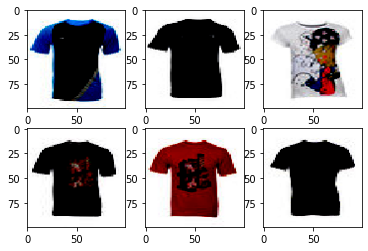

In [83]:
plt.title('sample images')

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i+5])
#     show_image(X[i])

In [62]:
def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = tf.keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size))

    # The decoder
    decoder = tf.keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(L.Reshape(img_shape))

    return encoder, decoder

In [63]:
encoder, decoder = build_autoencoder(IMG_SHAPE, code_size=code_size)

In [64]:
len(decoder.trainable_weights)

2

In [29]:
def build_deep_autoencoder(img_shape, code_size):
    """PCA's deeper brother. See instructions above. Use `code_size` in layer definitions."""
    H,W,C = img_shape
    
    # encoder
    encoder = tf.keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    
    ### YOUR CODE HERE: define encoder as per instructions above ###
    encoder.add(L.Conv2D(filters=32, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=128, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=256, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size))

    # decoder
    decoder = tf.keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    
    ### YOUR CODE HERE: define decoder as per instructions above ###
    decoder.add(L.Dense(2*2*256))
    decoder.add(L.Reshape((2, 2, 256)))
    decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
#     decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
#     decoder.add(Reshape(img_shape))
    
    return encoder, decoder

In [32]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              2048      
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 128)         295040    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 64)          73792     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 3)         867       
Total params: 390,211
Trainable params: 390,211
Non-trainable params: 0
________________________________________________

In [65]:
# Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512]:
    tf.keras.backend.clear_session()
#     encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=code_size)
    encoder, decoder = build_autoencoder(IMG_SHAPE, code_size=code_size)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:]==(code_size,),"encoder must output a code of required size"
    assert decoder.output_shape[1:]==IMG_SHAPE,   "decoder must output an image of valid shape"
#     assert len(encoder.trainable_weights)>=6,     "encoder must contain at least 3 layers"
#     assert len(decoder.trainable_weights)>=6,     "decoder must contain at least 3 layers"
    
    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)"%(layer.name,get_dim(layer))

print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
All tests passed!


In [66]:
inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

In [67]:
autoencoder = tf.keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

In [68]:
# we will save model checkpoints here to continue training in case of kernel death
model_filename = './models/autoencoder.{0:03d}.hdf5'
last_finished_epoch = None

In [69]:
class ModelSaveCallback(tf.keras.callbacks.Callback):
    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))

In [70]:
autoencoder.fit(x=X_train, y=X_train, epochs=5,
                validation_data=[X_test, X_test],
                callbacks=[ModelSaveCallback(model_filename)],
                           #keras_utils.TqdmProgressCallback()],
                verbose=1,
                initial_epoch=last_finished_epoch or 0)

Epoch 1/5
29/29 [==============================] - 24s 834ms/step - loss: 4.0999 - val_loss: 0.0000e+00
Epoch 2/5
29/29 [==============================] - 16s 564ms/step - loss: 0.3200 - val_loss: 0.0000e+00
Epoch 3/5
29/29 [==============================] - 16s 538ms/step - loss: 0.2137 - val_loss: 0.0000e+00
Epoch 4/5
29/29 [==============================] - 15s 533ms/step - loss: 0.1921 - val_loss: 0.0000e+00
Epoch 5/5
29/29 [==============================] - 17s 601ms/step - loss: 0.1797 - val_loss: 0.0000e+00


In [71]:
images = X_train
codes = encoder.predict(images) 
assert len(codes) == len(images)

In [72]:
from sklearn.neighbors import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes)

NearestNeighbors(metric='euclidean')

In [73]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"
    code = encoder.predict(image[None])
    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)
    print('printing indexess...',idx)
    return distances,images[idx]

In [74]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=3)
    
    plt.figure(figsize=[8,7])
    plt.subplot(1,4,1)
    show_image(image)
    plt.title("Original image")
    
    for i in range(3):
        plt.subplot(1,4,i+2)
        show_image(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

printing indexess... [185 160  49]


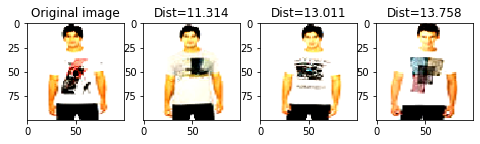

In [85]:
show_similar(X_test[2])

printing indexess... [124 727 270]


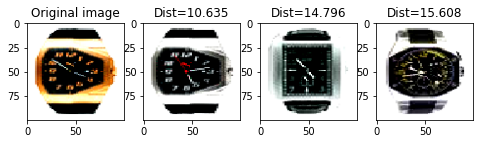

In [90]:
show_similar(X_test[15])

printing indexess... [281 129 449]


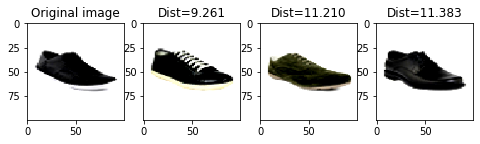

In [94]:
show_similar(X_test[25])